# (1.) Feature Extractor จาก VGG

สร้าง Model จำแนกรูปภาพ แมว สุนัข (2 คลาส) โดยใช้วิธี Transfer Learning แบบ Feature Extractor

ใช้จำนวนรูปภาพ 600 ภาพ (รวม 2 คลาส) สำหรับการ Train จะเห็นว่ามี accuracy สูงกว่า บทที่แล้ว

## Setup

อิมพอร์ตไลบารี ตั้งค่าต่างๆ โหลดข้อมูล

In [1]:
# Transfer Learning : Cat Dog
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
target_img_shape=(64,64)    # ขนาดภาพอินพุตเข้าสู่ Model (W x H)

train_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/train_set'   # สำหรับ Train
val_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/val_set'   # สำหรับ Validation
test_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/test_set'   # สำหรับ Test

# Process input แปลงข้อมูลภาพให้อยู่ในสเกลสำหรับ Model VGG16 (+ Data Augmentation ที่ Train)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,     # มุมหมุน +-20
                                   height_shift_range=0.15,     # ระยะเลื่อนแนวดิ่ง +-0.15
                                   width_shift_range=0.15,     # ระยะเลื่อนแนวนอน
                                   shear_range=0.9,     # การเฉือน
                                   zoom_range=0.2,     # ค่าซูม
                                   horizontal_flip=True,     # พลิกแนวนอน
                                   fill_mode='nearest')     # โหมดเติมพิกเซลภาพ
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# อ่านไฟล์ภาพจากโฟลเดอร์ ลดสเกล จัดแบ่งเป็น Batch
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=target_img_shape,   # ลดสเกลภาพ
                                              batch_size=32,      # แบ่งเป็น Batch ละ 32 ภาพ
                                              class_mode='binary')    # คลาสแบบ Binary
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,
                                              class_mode='binary')

Found 600 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


## ตรวจสอบข้อมูล

ตรวจสอบมิติข้อมูล จะพบว่า Batch size มีขนาด 32 ส่วนมิติ Image คือ 64x64x3 ตามที่กำหนดไว้ในคำสั่งโหลดภาพ flow_from... (target_size=... และ batch_size=32)

In [3]:
batch = train_set.next()
print(batch[0].shape)
print(batch[1].shape)

(32, 64, 64, 3)
(32,)


ดูตัวอย่างคลาสและทำ Visualization (รันแต่ละครั้งอาจไม่เหมือนเดิม เพราะเป็นการสุ่ม)

{'cat': 0, 'dog': 1}
(32, 64, 64, 3)
(32,)
0.0 0.9762226
class: 1.0


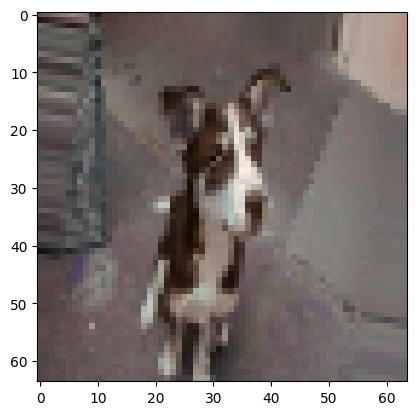

In [4]:
print(train_set.class_indices)  # อ่านภาพแล้วเข้ารหัสเป็นตัวเลขคลาส cat=0, dog=1
for image_batch, label_batch in train_set:
  print(image_batch.shape)  # ขนาด batch_size 32 ภาพ และภาพมีมิติ 64x64x3 channel
  print(label_batch.shape)    # จำนวน label ใน batch (จะเท่ากับ batch_size)

  img = image_batch[0] - image_batch[0].min()
  img /= 275.0    # Normalize ให้อยู่ช่วง 0-1
  print(img.min(), img.max())
  plt.imshow(img)     # แสดงภาพ

  print('class:', label_batch[0])     # ภาพอยู่ในคลาสใด
  break
plt.show()

ดูว่าแต่ละคลาสมีจำนวนข้อมูล (จำนวนภาพ) เท่าใด ทั้งใน Train และ Val

In [5]:
print('Training')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)    # คลาส id 0 และ 1
print(counts)     # จำนวนข้อมูลของคลาส 0 และ 1 ตามลำดับ

Training
[0 1]
[300 300]


In [ ]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)
print(counts)

Validation
[0 1]
[60 60]


## สร้าง Model

ภาพรวมของการสร้าง Model แบบ Transfer Learning คือ
- โหลด Pre-trained Model และ weight ที่ต้องการ (ในที่นี้ คือ VGG16) โดยสัดส่วน Top (Classification) ทิ้งไป จะเหลือส่วนที่เป็น Feature Extractor เท่านั้น
- ใส่ส่วน Top ที่ให้ตรงกับลักษณะงานเข้าไป (ตัด Top ของเดิมแล้วต่อของใหม่) ซึ่งในงานนี้เป็น Binary classification ก็จะใช้ Output Layer จำนวน 1 Node

เนื่องจากขนาด Input Image Default ของ Pre-trained VGG16 คือ 224x 224x3 แต่ในที่นี้เราต้องการใช้ 64x64x3 (กำหนดใช้ขนาดเล็ก จะได้รันไม่นานมาก)

ตั้งตัวแปรกำหนดมิติ input สำหรับ Model จากนั้นทำการโหลด Model และ weight

In [6]:
in_shape = (target_img_shape[0], target_img_shape[1], 3)    # (64,64,3)
in_shape

(64, 64, 3)

In [36]:
base_model = VGG16(include_top=False, input_shape=in_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

ดูโครงสร้างคร่าวๆ สังเกต input เป็น 64,64,3 ส่วน Output Layer จะไม่มี เนื่องจากถูกตัดทิ้งไป
- Total params: จำนวนพารามิเตอร์ (weight) รวมทั้งหมดของ Model
- Trainable params: จำนวนพารามิเตอร์ (weight) ที่สามารถ Train ได้ (หมายถึงขณะ Train ค่า weight ของ NN จะถูกอัปเดต)
- Non-trainable params: คือจำนวนพารามิเตอร์ (weight) ที่ Train ไม่ได้ คือจำนวน weight ที่ไม่เปลี่ยนแปลงขณะ Train

ที่ผ่านมา คือ base_model สำหรับใช้เป็นตัวฐานของ Model เรา (Feature Extractor) ลำดับต่อไป สร้าง Model โดยใช้ base_model เป็นฐาน แล้วใส่ส่วน Top หรือ Classificatiom ที่ต้องการเข้าไป ในที่นี้คือใส่ NN 128 + 1 จะได้ Model ที่มีกรตัดต่อแล้ว สำหรับวัตถุประสงค์ของงานนี้คือจำแนกภาพ แมว สุนัข 2 คลาส

In [37]:
model = Sequential()    # เริ่ม Model

model.add(base_model)     # ใส่ base_model เป็นฐาน
model.add(Flatten())
model.add(Dense(128, activation='relu'))      # ใส่ส่วน Top ที่ต้องการ
model.add(Dense(1, activation='sigmoid'))

model.summary()       # ดูสรุป

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14977089 (57.13 MB)
Trainable params: 14977089 (57.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ค่าพารามิเตอร์ มีส่วนเพิ่มเติมจากเดิม เกิดจาก weight และ bias ของชั้น Dense ที่เพิ่มไปใหม่
- 2x2x512 (จาก VGG16) x 128 + 128(bias) = 262,272
- weight 128 จาก Dense (ชั้น Dense128) + 1 bias ของตัวเอง = 129 รวมกับของเดิม (base_model) จะกลายเป็น 14,714,688 + 262,272 + 129 = 14,977,089

ตรวจสอบว่ามี Layer ใด ที่สามารถ Train ได้บ้าง (Train ได้ = Weight และ bias ถูกอัปเดตเหมือน Neural Network ทั่วไป)

In [9]:
for layer in model.layers:
  print('{:12} {}'.format(layer.name, layer.trainable))

vgg16        True
flatten      True
dense        True
dense_1      True


หรือใช้โค้ดนี้ก็ได้ ถ้าต้องการตรวจสอบ Model ทั้งหมด ให้ใช้โค้ดนี้

In [10]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


จะพบว่าที่สามารถ Train ได้มี VGG16 และ Dense ที่เพิ่มไป (เท่ากับว่า Train ได้ทั้งหมด)

แต่ว่าข้อนี้ต้องล็อกทุกชั้น Layer ใน VGG (base_model) ไม่ให้ Train ได้ (ล็อกส่วนที่เป็น Feature Extractor) เรียกว่าการทำ Freeze หรือล็อก Layer

In [38]:
base_model.trainable = False      # Freeze

ตรวจสอบอีกครั้งว่า Layer ใดบ้างmี่ Train ได้

In [39]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
dense_2/kernel:0
dense_2/bias:0
dense_3/kernel:0
dense_3/bias:0


จะพบว่าเหลือชั้น Classification (Dense) ที่เราใส่เพิ่มเข้าไปเท่านั้นที่สามารถ Train ได้

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14977089 (57.13 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


- พารามิเตอร์ที่ Train ได้จะลดลงจาก 14 ล้าน เหลือเพียง 2 แสนเศษเท่านั้น
- พารามิเตอร์ Train ได้ คือ 2048 (จาก VGG16) x 128 (weight) + 128 (bias) + 128 (weight จาก Dense_1) + 1 bias = 262,401

## Compile และ Train

ใช้ EarlyStopping และ ModelCheckPoint เพื่อบันทึกค่า Weight (.h5) ที่ดีที่สุด

In [41]:
import time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set,      # ชุดข้อมูล Train
                    validation_data=val_set,      # ชุดข้อมูล Validation
                    epochs=20, verbose=1,
                    callbacks=[es, mc])
end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 5.0637 - accuracy: 0.6717
Epoch 1: val_accuracy improved from -inf to 0.79167, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 6s 285ms/step - loss: 5.0637 - accuracy: 0.6717 - val_loss: 2.0994 - val_accuracy: 0.7917
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.8289 - accuracy: 0.8050
Epoch 2: val_accuracy did not improve from 0.79167
19/19 [==============================] - 3s 140ms/step - loss: 1.8289 - accuracy: 0.8050 - val_loss: 2.2294 - val_accuracy: 0.7583
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.9949 - accuracy: 0.8483
Epoch 3: val_accuracy improved from 0.79167 to 0.80000, saving model to best_model.h5
19/19 [==============================] - 3s 176ms/step - loss: 0.9949 - accuracy: 0.8483 - val_loss: 1.4583 - val_accuracy: 0.8000
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.8733
Epoch 4: val_accuracy improved from 0.80000 to 0.82500, saving model to best_model.h5
19/19 [==============================] - 3s 170ms/step - loss: 0.6225 - accuracy: 0.8733 - val_loss: 0

การ Train จะใช้เวลานานกว่าเดิม เนื่องจาก Model มีความซับซ้อนมากกว่า (เป็น Deep Learning Network มีความลึก 16 ชั้น) พล๊อต Loss และประเมิน Model ได้ความแม่นยำ 84.2%

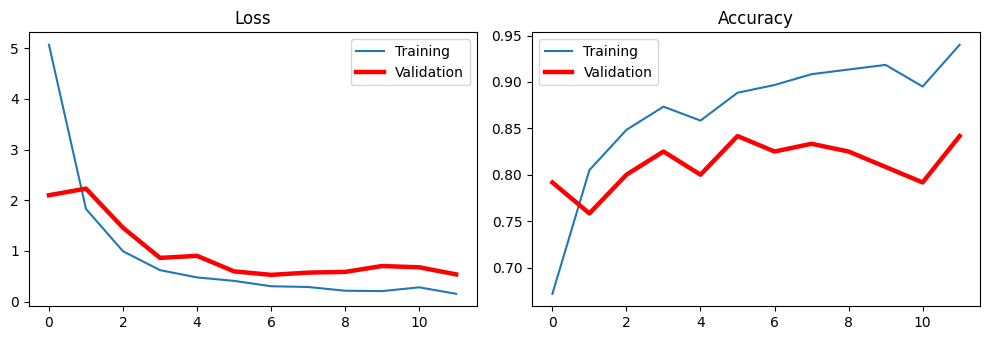

In [42]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
acc = model.evaluate(val_set, steps=len(val_set), verbose=1)    # ประเมิน
print('score = {:.3f}'.format(acc[1]))

4/4 [==============================] - 0s 75ms/step - loss: 0.5388 - accuracy: 0.8417
score = 0.842


## ทดสอบ

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_dog_cat(lst):
  y_pred = []; y_pred_cls = []; img_lst = []
  for i in lst:
    img = load_img(i, target_size=target_img_shape)
    img = img_to_array(img)
    img /= 255.0
    img_lst.append(img)

    img = np.expand_dims(img, axis=0)
    y_pred_i = model.predict(img)
    y_pred_cls_i = 'Dog' if y_pred_i > 0.5 else 'Cat'   # Threshold 0.5
    y_pred.append(y_pred_i)
    y_pred_cls.append(y_pred_cls_i)

  return img_lst, y_pred_cls, y_pred

In [19]:
import glob
import os
mylist = [f for f in glob.glob(test_dir+'/*')]
img_lst, y_pred_cls, y_pred = predict_dog_cat(mylist)

for i in mylist:
  print(os.path.basename(i), end="|")

1/1 [==============================] - 0s 20ms/step
10001.jpg|10002.jpg|10010.jpg|100.jpg|10.jpg|10004.jpg|10003.jpg|10006.jpg|1.jpg|10007.jpg|10009.jpg|1001.jpg|10005.jpg|10008.jpg|10000.jpg|1000.jpg|999.jpg|9989.jpg|9988.jpg|9986.jpg|9985.jpg|9987.jpg|

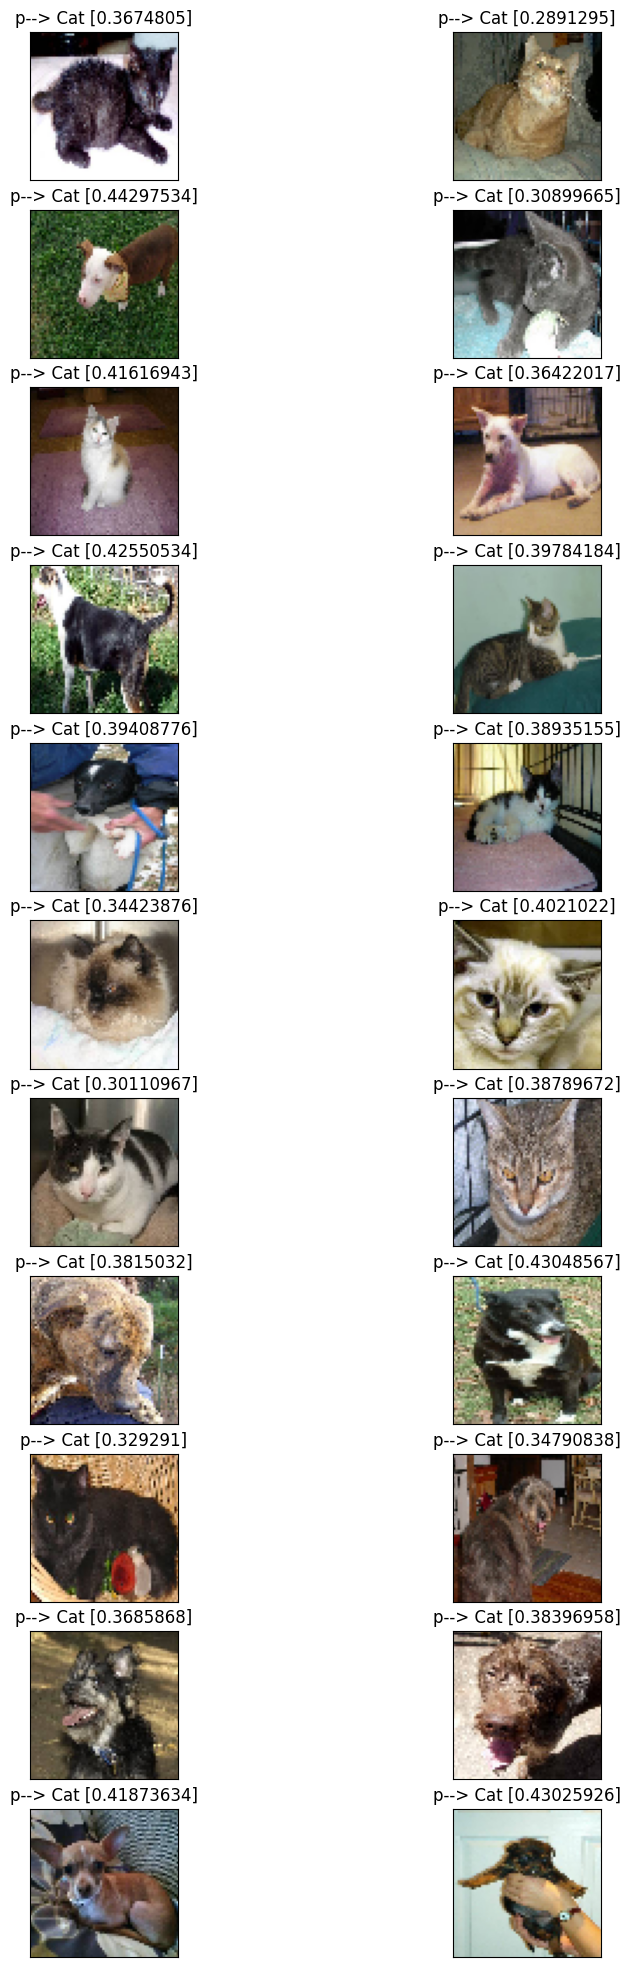

In [44]:
fig = plt.figure(figsize=(10, 25))
for i, k in enumerate(img_lst):   # วน loop อ่านค่า list แล้วพล็อต
  plt.subplot(11, 2, i+1)
  plt.imshow(k)
  plt.title('p--> {} {}'.format(y_pred_cls[i], y_pred[i][0]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# (2.) ปรับแต่งด้วย Fine-tuning

ปรับแต่งด้วย Fine-tuning ต่อจาก Feature Extractor โดยนำModel ที่ผ่านการ Train ก่อนหน้านี้ มาเปิดให้ชั้น Feature Extraction บางส่วนหรือทั้งหมด ทุกชั้นสามารถ Train ได้

## ปรับแต่งโมเดล

นำ Model จาก Workshop ที่แล้วมาทำต่อ เริ่มตรวจสอบอีกครั้งว่า Layer ใดสามารถ Train ได้บ้าง

In [45]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
dense_2/kernel:0
dense_2/bias:0
dense_3/kernel:0
dense_3/bias:0


จะพบว่า มีเพียง Classification (Dense) เท่านั้นที่สามารถ Train ได้ (Trainable) เนื่องจากก่อนหน้านี้ได้ทำการล็อกหรือ Freeze ชั้น Feature Extraction ทั้งหมด

ตอนนี้ต้องเปิดบางชั้น เพื่อให้ปรับแต่งด้วย Fine-tuning ซึ่งก็คือการเปิดให้บางส่วน Feature Extraction สามารถ Train ได้ (เมื่อทำการ Train แล้ว ค่า Weight, bias จะอัปเดตไปตามกระบวนการ Train หรือ Backpropagation)

เปิดหมดหรือเปิดบางส่วนก็ได้ ขึ้นอยู่กับว่าต้องการปรับปรุงจุดไหน ข้อนี้เปิดแต่ Conv block4 และ block5 โดยเริ่มจากปลดล็อกทั้งหมดก่อนแล้ว แล้วค่อยวนลูปเปิดชั้นที่ต้องการ

In [51]:
base_model.trainable = True    # ปลดล็อกก่อน !!!

for layer in base_model.layers:
  if layer.name[:11] == 'block5_conv':
    layer.trainable = True      # trainable
    print(layer.name, ' -> T')
  elif layer.name[:6] == 'block4':
    layer.trainable = True      # trainable
    print(layer.name, ' -> T')
  else:
    layer.trainable = False     # Frozen
    print(layer.name, ' -> F')

input_2  -> F
block1_conv1  -> F
block1_conv2  -> F
block1_pool  -> F
block2_conv1  -> F
block2_conv2  -> F
block2_pool  -> F
block3_conv1  -> F
block3_conv2  -> F
block3_conv3  -> F
block3_pool  -> F
block4_conv1  -> T
block4_conv2  -> T
block4_conv3  -> T
block4_pool  -> T
block5_conv1  -> T
block5_conv2  -> T
block5_conv3  -> T
block5_pool  -> F


In [53]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_2/kernel:0
dense_2/bias:0
dense_3/kernel:0
dense_3/bias:0


## Train

ปกติการทำ Fine-tuning จะใช้ค่า Learning Rate น้อยๆ หากกำหนดค่าสูงไป อาจทำให้ค่าประสิทธิภาพแย่ลงกว่าการทำ Feature Extractor อย่างเดียว

ข้อนี้ตั้งค่า lr - 1e-5

In [55]:
from tensorflow.keras.optimizers import Adam
import time

opt = Adam(learning_rate=1e-5)      # Learning Rate
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, steps_per_epoch=len(train_set),
                    validation_data=val_set, validation_steps=len(val_set),
                    epochs=10+10, verbose=1, callbacks=[es, mc])
end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9233
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 9s 201ms/step - loss: 0.1998 - accuracy: 0.9233 - val_loss: 0.6174 - val_accuracy: 0.8667
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9267
Epoch 2: val_accuracy improved from 0.86667 to 0.88333, saving model to best_model.h5
19/19 [==============================] - 6s 315ms/step - loss: 0.1647 - accuracy: 0.9267 - val_loss: 0.4250 - val_accuracy: 0.8833
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9483
Epoch 3: val_accuracy did not improve from 0.88333
19/19 [==============================] - 4s 197ms/step - loss: 0.1343 - accuracy: 0.9483 - val_loss: 0.4899 - val_accuracy: 0.8333
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9417
Epoch 4: val_accuracy did not improve from 0.88333
19/19 [==============================] - 6s 310ms/step - loss: 0.1665 - accuracy: 0.9417 - val_loss: 0.7190 - val_accuracy: 0.8250
Epoch 

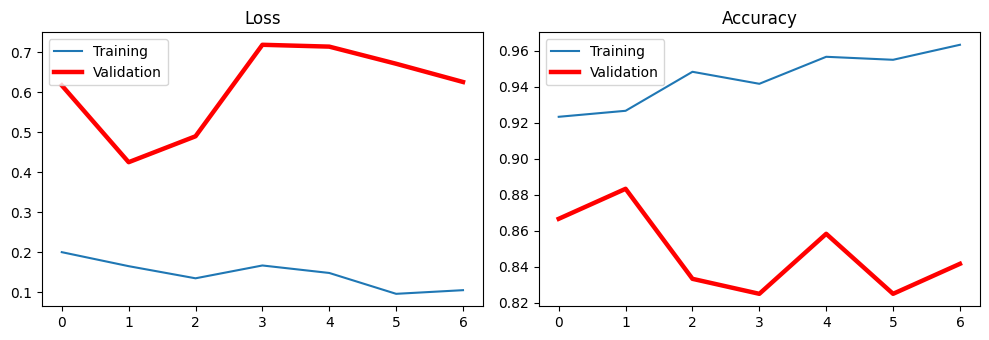

In [56]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
acc = model.evaluate(val_set, steps=len(val_set), verbose=1)    # ประเมิน
print('score = {:.3f}'.format(acc[1]))

4/4 [==============================] - 0s 85ms/step - loss: 0.6259 - accuracy: 0.8417
score = 0.842


Fine-tuning ถือเป็น Option บางครั้งทำแล้ว อาจได้ค่า Score ที่ดีขึ้น หรือเท่าเดิม อาจแย่ลง หรือเกิด Overfitting ขึ้นได้ บางกรณีทำเพียง Feature Extractor ก็ได้ค่าที่ดี สามารถเอาไปใช้ได้แล้ว

# (3.) Transfer Learning จาก ResNet

ทำ Transfer Learning โดยใช้ Pre-trained Model ResNet50 ทำเหมือนที่ผ่านมา คือ โหลด Pre-train มาเป็น base_model จากนันใส่ส่วน Top ตามลักษณะงานที่ใช้

ข้อสำคัญคือ อิมพอร์ต preprocess_input ของ API model นั้นๆมาด้วย เนื่องจากแต่ละ Model อาจใช้การ Normalze ข้อมูลภาพที่แตกต่างกัน และอย่าลืมต้องโหลดข้อมูลภาพใหม่ (สั่ง Normalize ใหม่)

In [59]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
target_img_shape=(64,64)    # ขนาดภาพอินพุตเข้าสู่ Model (W x H)

train_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/train_set'   # สำหรับ Train
val_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/val_set'   # สำหรับ Validation
test_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_vs_cat/test_set'   # สำหรับ Test

# Process input แปลงข้อมูลภาพให้อยู่ในสเกลสำหรับ Model ResNet (+ Data Augmentation ที่ Train)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,     # มุมหมุน +-20
                                   height_shift_range=0.15,     # ระยะเลื่อนแนวดิ่ง +-0.15
                                   width_shift_range=0.15,     # ระยะเลื่อนแนวนอน
                                   shear_range=0.9,     # การเฉือน
                                   zoom_range=0.2,     # ค่าซูม
                                   horizontal_flip=True,     # พลิกแนวนอน
                                   fill_mode='nearest')     # โหมดเติมพิกเซลภาพ
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# อ่านไฟล์ภาพจากโฟลเดอร์ ลดสเกล จัดแบ่งเป็น Batch
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=target_img_shape,   # ลดสเกลภาพ
                                              batch_size=32,      # แบ่งเป็น Batch ละ 32 ภาพ
                                              class_mode='binary')    # คลาสแบบ Binary
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,
                                              class_mode='binary')

Found 600 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [61]:
base_model = ResNet50(include_top=False,
                      weights='imagenet', input_shape=(64, 64, 3))    # input shape

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))      # ใส่ส่วน Top ที่ต้องการ
model.add(Dense(1, activation='sigmoid'))

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24636545 (93.98 MB)
Trainable params: 24583425 (93.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [62]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
conv1_conv/kernel:0
conv1_conv/bias:0
conv1_bn/gamma:0
conv1_bn/beta:0
conv2_block1_1_conv/kernel:0
conv2_block1_1_conv/bias:0
conv2_block1_1_bn/gamma:0
conv2_block1_1_bn/beta:0
conv2_block1_2_conv/kernel:0
conv2_block1_2_conv/bias:0
conv2_block1_2_bn/gamma:0
conv2_block1_2_bn/beta:0
conv2_block1_0_conv/kernel:0
conv2_block1_0_conv/bias:0
conv2_block1_3_conv/kernel:0
conv2_block1_3_conv/bias:0
conv2_block1_0_bn/gamma:0
conv2_block1_0_bn/beta:0
conv2_block1_3_bn/gamma:0
conv2_block1_3_bn/beta:0
conv2_block2_1_conv/kernel:0
conv2_block2_1_conv/bias:0
conv2_block2_1_bn/gamma:0
conv2_block2_1_bn/beta:0
conv2_block2_2_conv/kernel:0
conv2_block2_2_conv/bias:0
conv2_block2_2_bn/gamma:0
conv2_block2_2_bn/beta:0
conv2_block2_3_conv/kernel:0
conv2_block2_3_conv/bias:0
conv2_block2_3_bn/gamma:0
conv2_block2_3_bn/beta:0
conv2_block3_1_conv/kernel:0
conv2_block3_1_conv/bias:0
conv2_block3_1_bn/gamma:0
conv2_block3_1_bn/beta:0
conv2_block3_2_conv/kernel:0
conv2_block3_2_conv/bias:0


ทำการ Freeze ที่ base_model ทั้งหมด

In [63]:
base_model.trainable = False

In [64]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


ทำการ Train

In [65]:
import time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set,      # ชุดข้อมูล Train
                    validation_data=val_set,      # ชุดข้อมูล Validation
                    epochs=20, verbose=1,
                    callbacks=[es, mc])
end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 2.4370 - accuracy: 0.6383
Epoch 1: val_accuracy improved from -inf to 0.74167, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 10s 248ms/step - loss: 2.4370 - accuracy: 0.6383 - val_loss: 1.2290 - val_accuracy: 0.7417
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7750
Epoch 2: val_accuracy improved from 0.74167 to 0.85833, saving model to best_model.h5
19/19 [==============================] - 4s 194ms/step - loss: 0.6043 - accuracy: 0.7750 - val_loss: 0.4643 - val_accuracy: 0.8583
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8183
Epoch 3: val_accuracy did not improve from 0.85833
19/19 [==============================] - 3s 166ms/step - loss: 0.3813 - accuracy: 0.8183 - val_loss: 0.5170 - val_accuracy: 0.8250
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8400
Epoch 4: val_accuracy did not improve from 0.85833
19/19 [==============================] - 3s 144ms/step - loss: 0.3791 - accuracy: 0.8400 - val_loss: 0.6412 - val_accuracy: 0.8250
Epoch

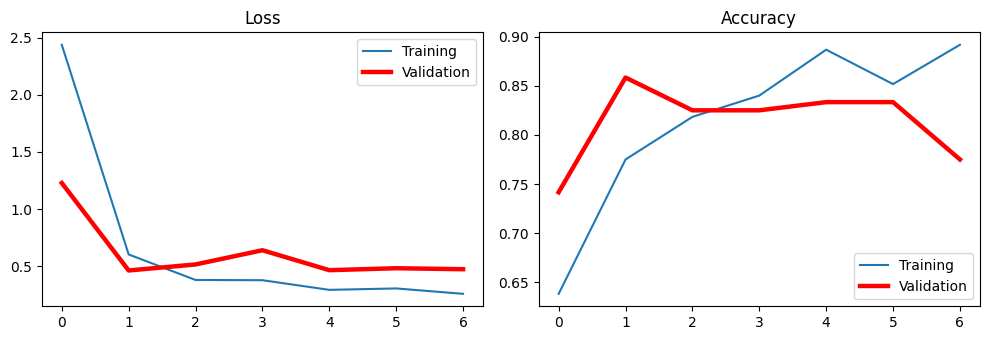

In [66]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
acc = model.evaluate(val_set, steps=len(val_set), verbose=1)    # ประเมิน
print('score = {:.3f}'.format(acc[1]))

4/4 [==============================] - 0s 83ms/step - loss: 0.4752 - accuracy: 0.7750
score = 0.775


# (4.) Transefer Learning จำแนก สุนัข แมว ช้าง

workshop นี้ต้องสร้าง model จำแนกภาพว่าเป็นสัตว์อะไร แบบ 3 คลาส คือ แมว สุนัข ช้าง (Multi-class Image Classification) ใช้ Pre-trained Model คือ ResNet50

## Setup และโหลด Dataset

อิมพอร์ตไลบารี และ Pre-trained พร้อมกับ preprocess_input ของ API Model ด้วย

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

สเปคของ ResNet50 มีขนาด Input Image 224 x 224 แต่ในที่นี้ใช้ขนาด 128x128 เพื่อให้ประมวลผล หรือ Train ได้เร็วขึ้น

In [2]:
target_img_shape=(128, 128)    #W x H

train_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/train'   # Train
val_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/val'   # Validation
test_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/test'   # Test

อ่านข้อมูลไฟล์ภาพ ทำ preprocess แบ่งเป็น batch และกำหนดโหมด Classification (class_mode) โดยสามารถกำหนดโหมดได้ ดังนี้
- categorical สำหรับ 2D One-hot encoded label
- binary สำหรับ 1D binary label
- sparse สำหรับ 1D integer label

workshop นี้เป็น Multi-classification สามารถกำหนด class_mode ใช้ได้ทั้ง categorical หรือ sparse แต่ในที่นี้เลือกใช้ sparse เพราะไม่ต้องทำ One-hot encoded ที่ Label

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# อ่านไฟล์ภาพจากโฟลเดอร์ ปรับสเกล จัดแบ่งเป็น Batch
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,      # แบ่งเป็น Batch ละ 32 ภาพ
                                              class_mode='sparse')    # Multi class
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,
                                              class_mode='sparse')

Found 30 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


## Visualize

ดูภาพบางภาพ (ทำงานแบบสุ่ม กดรันแต่ละครั้งภาพจะเปลี่ยนไป)

{'cat': 0, 'dog': 1, 'elephant': 2}
(30, 128, 128, 3)
(30,)
0.0 0.9412364
class: 2.0


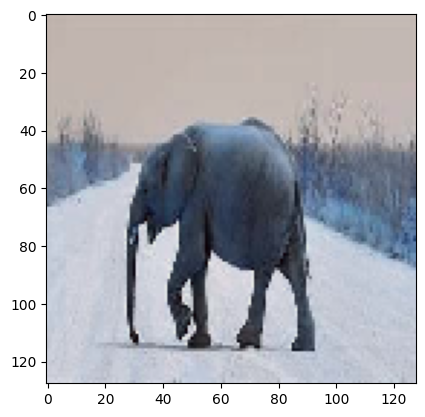

In [6]:
print(train_set.class_indices)  # อ่านภาพแล้วเข้ารหัสเป็นตัวเลขคลาส cat=0, dog=1, elephant=2
for image_batch, label_batch in train_set:
  print(image_batch.shape)  # ขนาด batch_size มีเพียง 30 ภาพ และภาพมีมิติ 128x128x3 channel
  print(label_batch.shape)    # จำนวน label ใน batch (จะเท่ากับ batch_size ของ Train)

  img = image_batch[0] - image_batch[0].min()
  img /= 275.0    # Normalize ให้อยู่ช่วง 0-1
  print(img.min(), img.max())
  plt.imshow(img)     # แสดงภาพ

  print('class:', label_batch[0])     # ภาพอยู่ในคลาสใด
  break
plt.show()

สรุปข้อมูลแต่ละคลาส มีจำนวนข้อมูลเท่าใด

In [8]:
print('Training')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)    # คลาส id 0, 1, 2
print(counts)     # จำนวนข้อมูลของคลาส 0, 1, 2 ตามลำดับ
print()

print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)
print(counts)

Training
[0 1 2]
[10 10 10]

Validation
[0 1 2]
[3 3 3]


สัดส่วนจำนวน Dataset ระหว่าง Validation กับ Training ควรมี Validation ไม่น้อยกว่า 10%

In [9]:
_, train_count = np.unique(train_set.classes, return_counts=True)
_, val_count = np.unique(val_set.classes, return_counts=True)

print('Ratio Validation/Training set:', val_count/train_count * 100)

Ratio Validation/Training set: [30. 30. 30.]


## Model

ภาพรวมการสร้าง Model แบบ Transfer Learning คือ
- โหลด Pre-trained Model และ weight ที่ต้องการ โดยตัดส่วน Top (Classification) ทิ้งไป จะเหลือส่วนที่เป็น Feature Extractor เท่านั้น
- ใส่ส่วน Top ที่ตรงกับลักษณะงานเข้าไป (เท่ากับว่าตัด Top ของเดิมแล้วต่อของใหม่เข้าไป) ซึ่งงานนี้เป็น Multi-class Classification 3 คลาส ใช้ Output Layer จำนวน 3 Node และส่วนก่อน Output Layer ออกแบบไว้ให้มี 2 ชั้น คือ 256 -> 128 -> 3(output layer)

เนื่องจากขนาดอินพุต default ของ ResNet50 คือ 224x224x3 แต่ที่เราใช้คือ 128x128x3 จึงต้องกำหนดขนาด input คือ 128x128x3 ซึ่งเท่ากับที่โหลด และ resize ตแนอ่านด้วย .flow_from...

In [4]:
base_model = ResNet50(include_top=False,      # ตัดส่วน Top ทิ้งไป
                      weights='imagenet',        # Load weight
                      input_shape=(target_img_shape[0], target_img_shape[1], 3))    # มิติ input shape

model = Sequential()
model.add(base_model)     # ตัวฐาน (Pre-trained)
model.add(Flatten())
model.add(Dense(256, activation='relu'))      # เพิ่มชั้น 256
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))   # Output 3 class

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                         

- Trainable params: จำนวนพารามิเตอร์ (weight) ที่สามารถ Train ได้ขณะนี้ ประมาณ 31 ล้าน

จึงต้องล็อกทุกชั้น Layer ในฐาน (base_model) ไม่ให้ Train ได้ (Freeze หรือล็อกส่วนที่เป็น Feature Extractor)

In [5]:
base_model.trainable = False      # Freeze Base

In [6]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0
dense_2/kernel:0
dense_2/bias:0


เหลือเพียงชั้น Top mี่เพิ่มเข้าไปที่ Train ได้ (256 -> 128 -> 3)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

พบว่า Trainable ลดลงเหลือ 8 ล้าน เท่ากับว่า การ Freeze มีผลแล้ว

## compile & train

ตัวอย่างเป็น Multi-class และใช้ class_mode = sparse ดังนั้นการ compile ต้องกำหนด loss ให้สอดคล้องกัน คือใช้ sparse_categorical_crossentropy

In [8]:
import time
model.compile(loss='sparse_categorical_crossentropy',    ###
              optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model3cls.h5', monitor='val_accuracy',
                     verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=20, verbose=1,
                    callbacks=[es, mc])
end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 4.1089 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to best_model3cls.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 17s 17s/step - loss: 4.1089 - accuracy: 0.3333 - val_loss: 12.3868 - val_accuracy: 0.5556
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 15.0243 - accuracy: 0.4667
Epoch 2: val_accuracy did not improve from 0.55556
1/1 [==============================] - 0s 330ms/step - loss: 15.0243 - accuracy: 0.4667 - val_loss: 6.7108 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 7.0784 - accuracy: 0.6333
Epoch 3: val_accuracy improved from 0.55556 to 0.88889, saving model to best_model3cls.h5
1/1 [==============================] - 1s 1s/step - loss: 7.0784 - accuracy: 0.6333 - val_loss: 0.3191 - val_accuracy: 0.8889
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 4.2615 - accuracy: 0.8000
Epoch 4: val_accuracy did not improve from 0.88889
1/1 [==============================] - 0s 234ms/step - loss: 4.2615 - accuracy: 0.8000 - val_loss: 1.3273 - val_accuracy: 0.7778
Epoch 5/20
1/1 [=

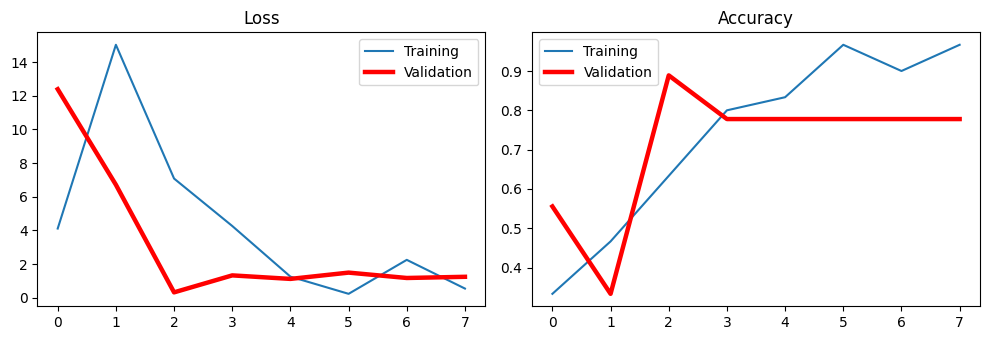

In [9]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

ประเมิน Model

In [10]:
acc = model.evaluate(val_set, steps=len(val_set), verbose=1)    # ประเมิน
print('score = {:.3f}'.format(acc[1]))

1/1 [==============================] - 0s 104ms/step - loss: 1.2429 - accuracy: 0.7778
score = 0.778


## การใช้งาน predict

In [13]:
labels = train_set.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'cat', 1: 'dog', 2: 'elephant'}

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict(lst):
  pred = []; pred_cls = []; img_lst = []
  for i in lst:
    img = load_img(i, target_size=target_img_shape)   # (128, 128)
    img_lst.append(img)
    img = img_to_array(img)

    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    pred_i = np.round(model.predict(img), decimals=3)
    pred_cls_i = labels[np.argmax(pred_i, -1)[0]]
    pred.append(pred_i)
    pred_cls.append(pred_cls_i)

  return img_lst, pred_cls, pred

In [44]:
import glob
import os
mylist = [f for f in glob.glob(test_dir+'/*')]
img_lst, y_pred_cls, y_pred = predict(mylist)

for i in mylist:
  print(os.path.basename(i), end="|")

1/1 [==============================] - 0s 26ms/step
10004.jpg|9873.jpg|9871.jpg|9870.jpg|9874.jpg|9872.jpg|ele_14.png|ele_15.png|ele_16.png|

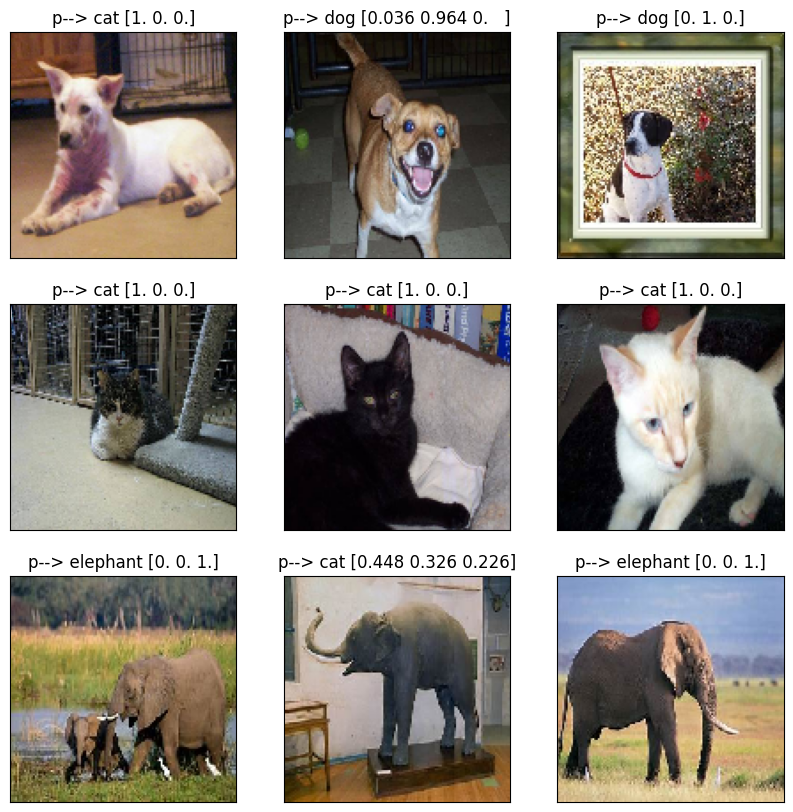

In [47]:
fig = plt.figure(figsize=(10, 10))
for i, k in enumerate(img_lst):   # วน loop อ่านค่า list แล้วพล็อต
  plt.subplot(3, 3, i+1)
  plt.imshow(k)
  plt.title('p--> {} {}'.format(y_pred_cls[i], y_pred[i][0]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# (5.) Transfer Learning จาก MobileNet

ทำเหมือน Workshop 4 แต่เปลี่ยนมาใช้ MobileNet โดย Google (มีหลักการทำงานแบบ Depthwise Convolution และ Pointwise Convolution) มีจุดเด่นที่ Model และ Weight มีขนาดเล็กกว่าตัวอื่นๆ เช่น เล็กกว่า VGG16, ResNet50

การ Process ของแต่ละสถาปัตยกรรมอาจแตกต่างกัน ให้ใช้ฟังก์ชัน preprocess_input ของใครของมัน

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ขนาด input_shape ของภาพที่ใช้งานได้ มีให้เลือก [96, 128, 160, 192, 224] ใน workshop นี้ใช้ 128

In [54]:
target_img_shape=(128, 128)    #W x H

train_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/train'   # Train
val_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/val'   # Validation
test_dir = '/content/drive/MyDrive/deep_greenbook/datasets/dog_cat_ele/test'   # Test

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# อ่านไฟล์ภาพจากโฟลเดอร์ ปรับสเกล จัดแบ่งเป็น Batch
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,      # แบ่งเป็น Batch ละ 32 ภาพ
                                              class_mode='sparse')    # Multi class
val_set = val_datagen.flow_from_directory(val_dir,
                                              target_size=target_img_shape,
                                              batch_size=32,
                                              class_mode='sparse')

Found 30 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


เนื่องจาก Preprocess ของ MobileNet จะปรับสเกลภาพให้อยู่ในช่วง -1 ถึง 1 *ทำให้การ preview เพื่อดูข้อมูลครั้งนี้ จะแตกต่างกับ workshop ที่ผ่านมา*

{'cat': 0, 'dog': 1, 'elephant': 2}
(30, 128, 128, 3)
(30,)
0.0 1.0
class: 0.0


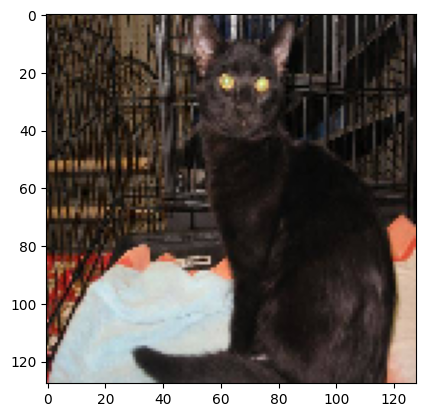

In [56]:
print(train_set.class_indices)  # อ่านภาพแล้วเข้ารหัสเป็นตัวเลขคลาส cat=0, dog=1, elephant=2
for image_batch, label_batch in train_set:
  print(image_batch.shape)  # ขนาด batch_size มีเพียง 30 ภาพ และภาพมีมิติ 128x128x3 channel
  print(label_batch.shape)    # จำนวน label ใน batch (จะเท่ากับ batch_size ของ Train)

  img = image_batch[0] - image_batch[0].min()
  img /= 2.0    # Normalize ให้อยู่ช่วง 0-1 (แค่ตอน Preview เท่านั้น)
  print(img.min(), img.max())
  plt.imshow(img)     # แสดงภาพ

  print('class:', label_batch[0])     # ภาพอยู่ในคลาสใด
  break
plt.show()

สร้าง Model และ Train

In [57]:
base_model = MobileNetV2(include_top=False,      # ตัดส่วน Top ทิ้งไป
                      weights='imagenet',        # Default
                      input_shape=(target_img_shape[0], target_img_shape[1], 3))    # มิติ input shape

model = Sequential()
model.add(base_model)     # ตัวฐาน (Pre-trained)
model.add(Flatten())
model.add(Dense(256, activation='relu'))      # เพิ่มชั้น 256
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))   # Output 3 class

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0 

Trainable params มีอยู่ 7.5 ล้าน ต้องทำการ Freeze ที่ base_model ก่อน

In [58]:
base_model.trainable = False      # Freeze Base

In [59]:
print("Trainable...\n---")
for var in model.trainable_variables:
  print(var.name)

Trainable...
---
dense_3/kernel:0
dense_3/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

Trainable params เหลืออยู่ 5.2 ล้าน

In [61]:
import time
model.compile(loss='sparse_categorical_crossentropy',    ###
              optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model3cls.h5', monitor='val_accuracy',
                     verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=20, verbose=1,
                    callbacks=[es, mc])
end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 1.9959 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to best_model3cls.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 8s 8s/step - loss: 1.9959 - accuracy: 0.3333 - val_loss: 0.3508 - val_accuracy: 0.7778
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9000
Epoch 2: val_accuracy improved from 0.77778 to 1.00000, saving model to best_model3cls.h5
1/1 [==============================] - 1s 621ms/step - loss: 0.1872 - accuracy: 0.9000 - val_loss: 0.1285 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.8333
Epoch 3: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 179ms/step - loss: 0.7785 - accuracy: 0.8333 - val_loss: 0.6074 - val_accuracy: 0.6667
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.9333
Epoch 4: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 199ms/step - loss: 0.3437 - accuracy: 0.9333 - val_loss: 0.0663 - val_accuracy: 1.0000
Epoch 5/20
1/1 [===

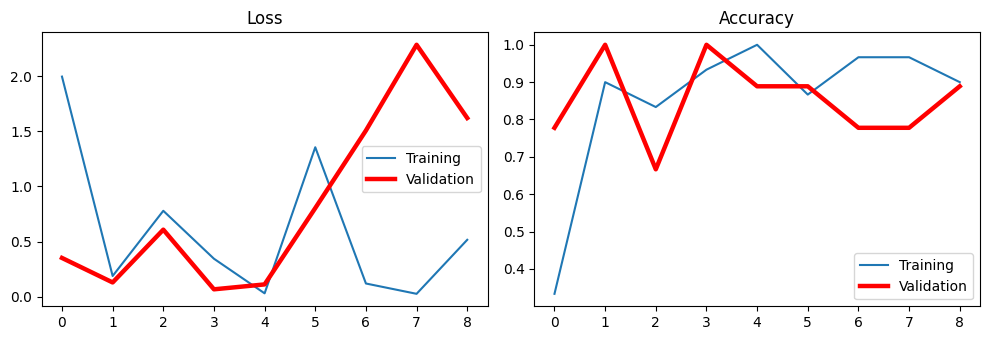

In [62]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')
plt.legend()

plt.tight_layout()
plt.show()

ดูจาก accuracy แล้ว มีประสิทธิภาพสูงกว่า ResNet50 ของ workshop 4

In [63]:
acc = model.evaluate(val_set, steps=len(val_set), verbose=1)    # ประเมิน
print('score = {:.3f}'.format(acc[1]))

1/1 [==============================] - 0s 72ms/step - loss: 1.6201 - accuracy: 0.8889
score = 0.889
